In [1]:
#CNN - Cat v/s Dog
#data pre-processing is done manually
#importing keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [2]:
#initialising the CNN
classifier = Sequential()

In [3]:
#step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))

In [4]:
#step 2 - Max Pooling(dimension of pooling is always half the size of the feature map)
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [5]:
#step 3 - Flattening(it is done to gain information about the spatial structure of the picture)
classifier.add(Flatten())

In [6]:
#step 4 - Full Connection(ANN)
classifier.add(Dense(128, activation = 'relu'))     #hidden layer
classifier.add(Dense(1, activation = 'sigmoid'))     #output layer

In [7]:
#compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
#fitting CNN to the images
from keras.preprocessing.image import ImageDataGenerator

In [9]:
#image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [12]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-11-21 12:11:33--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   247MB/s    in 3.2s    

2020-11-21 12:11:37 (242 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [13]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [14]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [15]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [16]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

12365
12362
2365
2362


In [17]:
training_set = "/tmp/cats-v-dogs/training/"
test_set = "/tmp/cats-v-dogs/testing/"

print(len(os.listdir(training_set)))
print(len(os.listdir(test_set)))

2
2


In [18]:
#creating training set
training_set = train_datagen.flow_from_directory(training_set,
                                                 target_size = (64, 64),#target size dimensions are 64 and 64 as mentioned in step 1
                                                 batch_size = 32,
                                                 class_mode = 'binary')#class mode denotes the number of classes you want to predict(here it is binary since we have cats and dogs)

Found 24725 images belonging to 2 classes.


In [19]:
#creating test set
test_set = test_datagen.flow_from_directory(test_set,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary') 

Found 4726 images belonging to 2 classes.


In [20]:
#fitting the model
classifier.fit(training_set,#fits the model to the data
               steps_per_epoch = 90,#no. of images in training set(8000)
               epochs = 15,#25 is set for faster computation(50 is used)
               validation_data = test_set,
               validation_steps = 6)#no. of images in testing set(2000)

Epoch 1/15
90/90 [==============================] - 10s 113ms/step - loss: 0.6960 - accuracy: 0.5240 - val_loss: 0.6602 - val_accuracy: 0.5938
Epoch 2/15
90/90 [==============================] - 10s 112ms/step - loss: 0.6659 - accuracy: 0.5813 - val_loss: 0.6048 - val_accuracy: 0.7500
Epoch 3/15
90/90 [==============================] - 10s 111ms/step - loss: 0.6273 - accuracy: 0.6476 - val_loss: 0.6130 - val_accuracy: 0.6510
Epoch 4/15
90/90 [==============================] - 10s 112ms/step - loss: 0.6139 - accuracy: 0.6616 - val_loss: 0.5881 - val_accuracy: 0.6979
Epoch 5/15
90/90 [==============================] - 10s 112ms/step - loss: 0.6081 - accuracy: 0.6750 - val_loss: 0.6017 - val_accuracy: 0.6354
Epoch 6/15
90/90 [==============================] - 10s 113ms/step - loss: 0.5941 - accuracy: 0.6819 - val_loss: 0.5425 - val_accuracy: 0.7604
Epoch 7/15
90/90 [==============================] - 10s 111ms/step - loss: 0.5787 - accuracy: 0.7014 - val_loss: 0.5453 - val_accuracy: 0.6979

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 10s 111ms/step - loss: 0.5840 - accuracy: 0.7035 - val_loss: 0.5208 - val_accuracy: 0.7552
Epoch 9/15
90/90 [==============================] - 10s 112ms/step - loss: 0.5602 - accuracy: 0.7156 - val_loss: 0.5438 - val_accuracy: 0.7500
Epoch 10/15
90/90 [==============================] - 10s 112ms/step - loss: 0.5767 - accuracy: 0.7003 - val_loss: 0.5223 - val_accuracy: 0.7656
Epoch 11/15
90/90 [==============================] - 10s 111ms/step - loss: 0.5692 - accuracy: 0.7153 - val_loss: 0.5641 - val_accuracy: 0.7240
Epoch 12/15
90/90 [==============================] - 10s 112ms/step - loss: 0.5622 - accuracy: 0.7104 - val_loss: 0.5599 - val_accuracy: 0.7240
Epoch 13/15
90/90 [==============================] - 10s 113ms/step - loss: 0.5634 - accuracy: 0.7125 - val_loss: 0.5019 - val_accuracy: 0.7552
Epoch 14/15
90/90 [==============================] - 10s 113ms/step - loss: 0.5566 - accuracy: 0.7198 - val_loss: 0.5473 - val_accuracy: 0.7552
Epoch

Saving Dog1.jpg to Dog1 (1).jpg
[1.]


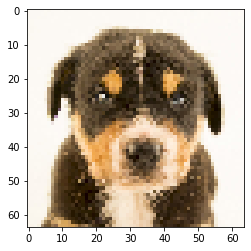

Dog1.jpg is a dog


In [21]:
import numpy as np
%matplotlib inline
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()
for fn in uploaded.keys(): 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = classifier.predict(images, batch_size=10)
  print(classes[0])
  plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Cat1.jpg to Cat1 (1).jpg
[0.]


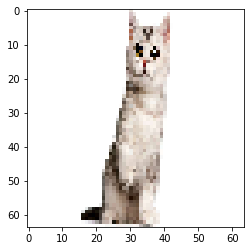

Cat1.jpg is a cat


In [22]:
uploaded = files.upload()
for fn in uploaded.keys(): 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = classifier.predict(images, batch_size=10)
  print(classes[0])
  plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Dog1.jfif to Dog1 (1).jfif
[1.]


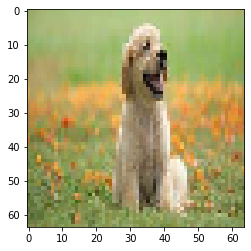

Dog1.jfif is a dog


In [23]:
uploaded = files.upload()
for fn in uploaded.keys(): 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = classifier.predict(images, batch_size=10)
  print(classes[0])
  plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Cat2.jpg to Cat2.jpg
[0.]


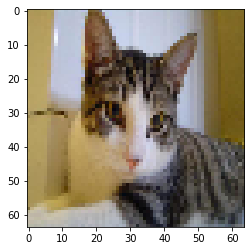

Cat2.jpg is a cat


In [24]:
uploaded = files.upload()
for fn in uploaded.keys(): 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = classifier.predict(images, batch_size=10)
  print(classes[0])
  plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")